<a href="https://colab.research.google.com/github/dmdiegoar/Quant-code-t0/blob/main/Copia_de_XGBOOST_GGAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-46-689463938.py:97: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GGAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-15 -> 2025-07-15)')
/tmp/ipython-input-46-689463938.py:97: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.tail of Price           Close       High        Low       Open   Volume high_lag_1  \
Ticker           GGAL       GGAL       GGAL       GGAL     GGAL              
Date                                                                         
2001-01-31  15.326560  15.465471  15.233952  15.233952   456600  15.372860   
2001-02-01  14.956127  15.419165  14.956127  15.419165   565700  15.465471   
2001-02-02  14.354179  15.095040  14.122660  15.002433   456600  15.419165   
2001-02-05  14.261569  14.539392  14.122658  14.354177   380500  15.095040   
2001-02-06  14.354179  14.585698  14.307876  14.307876   141400  14.539392   
...               ...        ...        ...        ...      ...        ...   
2025-07-08  50.689999  50.720001  47.799999  48.590000  1699700  50.730000   
2025-07-09  49.980000  51.709999  49.889999  51.200001  1527000  50.720001   
2025-07-10  48.709999  49.570000  48.189999  49.200001  1254000  51.709999   
2025-07-11  47.099998  48.580002  

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


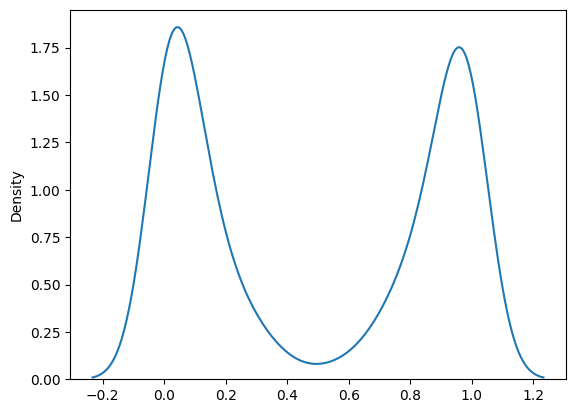

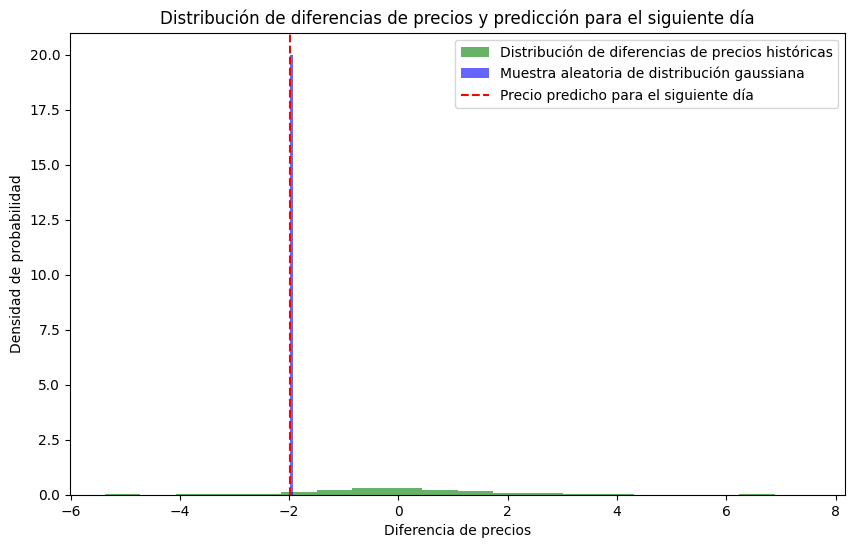

Precio esperado para el siguiente día (distribución gaussiana con derivadas): [44.80442579]
Probabilidad de que el precio predicho sea correcto: [0.87770901]
Papel:  GGAL
Precio actual: [46.79000092].  Corte: 2025-07-14 00:00:00  
Pronóstico de dirección del activo (1: subida, -1: bajada): -1
ROC-AUC en el conjunto de entrenamiento: 0.9998951107722891
ROC-AUC en el conjunto de prueba: 0.9648068783068783
Acción sugerida por la estrategia de trading: SELL


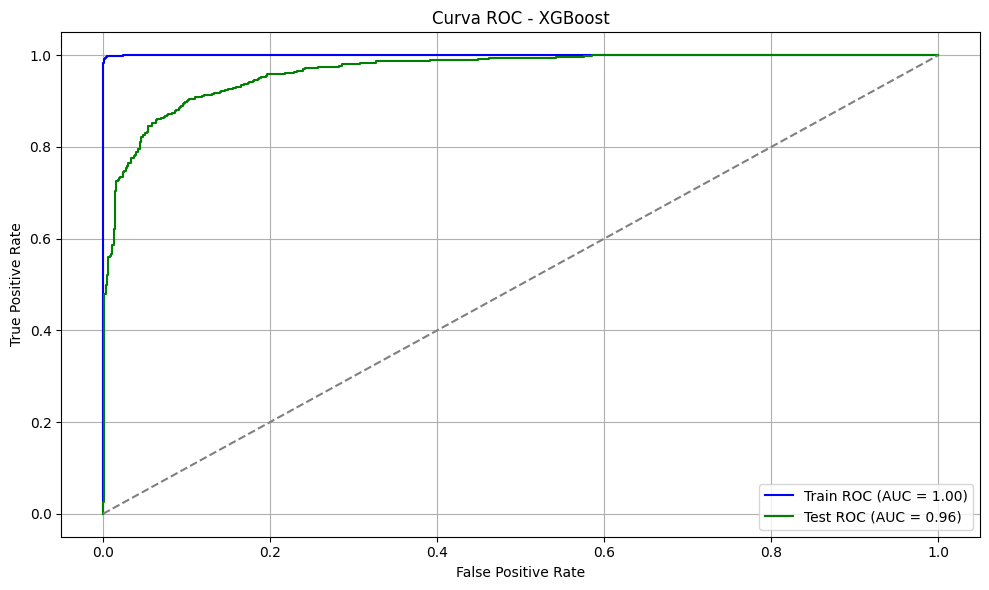

In [ ]:


import os
import seaborn as sns
from sklearn.mixture import GaussianMixture as mix
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from scipy.stats import norm
import time

def add_lagged_price_features(df):
    """
    Añade al DataFrame las columnas 'high', 'low', y 'close' con los valores rezagados de 'High', 'Low', y 'Close'.
    """
    df['high_lag_1'] = df['High'].shift(1)
    df['low_lag_1'] = df['Low'].shift(1)
    df['close_lag_1'] = df['Close'].shift(1)
    df['high_lag_2'] = df['High'].shift(2)
    df['low_lag_2'] = df['Low'].shift(2)
    df['close_lag_2'] = df['Close'].shift(2)
    df['high_lag_3'] = df['High'].shift(3)
    df['low_lag_3'] = df['Low'].shift(3)
    df['close_lag_3'] = df['Close'].shift(3)
    df['high_lag_4'] = df['High'].shift(4)
    df['low_lag_4'] = df['Low'].shift(4)
    df['close_lag_4'] = df['Close'].shift(4)
    df['high_lag_5'] = df['High'].shift(5)
    df['low_lag_5'] = df['Low'].shift(5)
    df['close_lag_5'] = df['Close'].shift(5)
    return df


# Definiciones de funciones para calcular indicadores técnicos
def calculate_RSI(series, period=7):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def calculate_ROC(series, period=5):
    return ((series - series.shift(period)) / series.shift(period)) * 100

def calculate_PPO(series, fast_period=5, slow_period=9, signal_period=5):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    ppo = (ema_fast - ema_slow) / ema_slow * 100
    signal_line = ppo.ewm(span=signal_period, adjust=False).mean()
    histogram = ppo - signal_line
    return ppo, signal_line, histogram

def calculate_volatility(series, window=20):
    return series.rolling(window).std()

def calculate_sma(series, period=5):
    # Calcular la media móvil simple (SMA) con el período dado para la serie dada
    return series.rolling(window=period).mean()

def calculate_sma21(series, period=21):
    # Calcular la media móvil simple (SMA) con el período dado para la serie dada
    return series.rolling(window=period).mean()

def calculate_sma30(series, period=7):
    # Calcular la media móvil simple (SMA) con el período dado para la serie dada
    return series.rolling(window=period).mean()

def calculate_christmas_rally(df):
    # Crear una columna para indicar si es noviembre o diciembre
    df['Is_November_December'] = df.index.month.isin([11, 12])
    # Crear una columna para indicar si es el rally navideño (desde noviembre hasta diciembre)
    df['Is_Christmas_Rally'] = df['Is_November_December']
    return df



# Función para calcular la época de balances
def calculate_earnings_season(df):

    df['Is_Earnings_Season'] = df.index.month.isin([1, 4, 7, 10])
    return df# Por ejemplo, podrías considerar los meses en los que la mayoría de las empresas reportan sus resultados trimestrales


# Función para obtener datos y crear características
def fetch_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    #print("data ta ta ta")
    #print(data)
    #time.sleep(16)
    #print("fench y ya")
    return data

# Función para obtener datos y crear features
def create_features(df):
    # Añadir características rezagadas
    df = add_lagged_price_features(df)

    # Calcular el cambio porcentual y agregar características retrasadas basadas en ello
    df['Pct_change'] = df['Close'].pct_change()
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Pct_change'].shift(lag)

    # Calcular los indicadores técnicos
    df['RSI'] = calculate_RSI(df['Close'])
    df['ROC'] = calculate_ROC(df['Close'])
    df['PPO'], df['PPO_Signal'], df['PPO_Histogram'] = calculate_PPO(df['Close'])


    # Calcular la media móvil simple y la volatilidad
    df["SMA"] = calculate_sma(df["Close"])
    df["SMA21"] = calculate_sma21(df["Close"])
    df["SMA30"] = calculate_sma30(df["Close"])

    df['Volatility'] = calculate_volatility(df['Close'])

    # Etiquetar los datos como subida o bajada (1 si es subida, 0 si es bajada)
    df['Label'] = (df['Pct_change'] > 0).astype(int)

    # Calcular el retorno
    df['Return'] = np.log(df['Close'] / df['Close'].shift())

    # Agregar características de la temporada de ganancias y el rally de Navidad
    df = calculate_earnings_season(df)
    df = calculate_christmas_rally(df)

    # Eliminar filas con valores faltantes resultantes de los cálculos anteriores
    df.dropna(inplace=True)

    return df


# Definición de símbolo y fechas
symbol ="GGAL"
#symbol ="COME.BA"
start_date ="2001-01-01"
end_date_today="2025-07-15"
current_data = fetch_data(symbol, end_date_today, end_date_today)

# Obtener datos
df = fetch_data(symbol, start_date, end_date_today)

# Crear features
df = create_features(df)
print(df.tail)

# Ordenar features y etiquetes
X = df[['RSI', 'ROC', 'PPO', 'PPO_Signal', 'PPO_Histogram', 'Volatility', 'SMA', "SMA21", "SMA30", 'Is_Christmas_Rally', 'Is_Earnings_Season'] + [f'lag_{i}' for i in range(1, 6)]]
y = df['Label']

# Calcular la información mutua entre las características X y la etiqueta y
mutual_info = mutual_info_classif(X, y)

# Mostrar la información mutua p cada característica
for feature, mi in zip(X.columns, mutual_info):
    print(f"Mutual Information for {feature}: {mi}")

# Definir el punto de división para el entrenamiento y la predicción
split = int(0.8*len(df))

# Preparar los datos excluyendo las columnas 'High', 'Low', 'Close'
df_features = df.drop(['High', 'Low', 'Open'], axis=1)


# Escalar los datos
scaler = StandardScaler()
ss = scaler
data_scaled = ss.fit_transform(df_features[:split])

# Escalar las características
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definir el clasificador XGBoost con parámetros personalizados
xgb_clf = XGBClassifier(
    learning_rate=0.1,  # Tasa de aprendizaje (por defecto es 0.1)
    max_depth=3,        # Profundidad máxima del árbol (por defecto es 3)
    n_estimators=900,
    objective='binary:logistic',
    subsample = 0.6
         # Número de árboles (por defecto es 100)

)

# Realizar validación cruzada
cv_scores = cross_val_score(xgb_clf, X_scaled, y, cv=5)

# Imprimir los puntajes de validación cruzada
print("CV Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Std CV Score:", np.std(cv_scores))

# Entrenar el modelo XGBoost en el conjunto de entrenamiento
xgb_clf.fit(X_train, y_train)

# Calcular las predicciones en el conjunto de entrenamiento y prueba
y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

# Predicciones de probabilidades en el conjunto de entrenamiento y prueba
y_train_prob_xgb = xgb_clf.predict_proba(X_train)
y_test_prob_xgb = xgb_clf.predict_proba(X_test)

sns.kdeplot(y_train_prob_xgb[:,1])

# Umbral para clasificar como 1
threshold = 0.5

# Recodificar las probabilidades en valores binarios
y_train_pred_bin_xgb = (y_train_prob_xgb[:, 1] > threshold).astype(int)
y_test_pred_bin_xgb = (y_test_prob_xgb[:, 1] > threshold).astype(int)


# Mostrar los primeros diez elementos resultantes
print("Predicciones binarias en el conjunto de entrenamiento (XGBoost):", y_train_pred_bin_xgb[:10])
print("Predicciones binarias en el conjunto de prueba (XGBoost):", y_test_pred_bin_xgb[:10])

# Imprimir las probabilidades
#print("Probabilidades en el conjunto de entrenamiento (XGBoost):\n", y_train_prob_xgb)
#print("Probabilidades en el conjunto de prueba (XGBoost):\n", y_test_prob_xgb)


# Calcular el R cuadrado en el conjunto de entrenamiento y de prueba
r2_train_xgb = xgb_clf.score(X_train, y_train)
r2_test_xgb = xgb_clf.score(X_test, y_test)

print("R cuadrado en el conjunto de entrenamiento (XGBoost):", r2_train_xgb)
print("R cuadrado en el conjunto de prueba (XGBoost):", r2_test_xgb)


def evaluacion_modelo(modelo, X_train, y_train, X_test, y_test):
    # Predicciones en el conjunto de entrenamiento y prueba
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    # Calcular las métricas para el conjunto de entrenamiento
    print("Métricas para el conjunto de entrenamiento:")
    print("------------------------------------------------------")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_train, y_train_pred))

    print("Precisión (Accuracy):", accuracy_score(y_train, y_train_pred))
    print("Informe de Clasificación:")
    print(classification_report(y_train, y_train_pred))

    # Calcular las métricas para el conjunto de prueba
    print("\nMétricas para el conjunto de prueba:")
    print("------------------------------------------------------")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_test_pred))

    print("Precisión (Accuracy):", accuracy_score(y_test, y_test_pred))
    print("Informe de Clasificación:")
    print(classification_report(y_test, y_test_pred))

# Uso de la función evaluacion_modelo
print("Evaluación del modelo en el conjunto de entrenamiento y prueba:")
print("------------------------------------------------------")
evaluacion_modelo(xgb_clf, X_train, y_train, X_test, y_test)

#### PREDICCIONES ####
# Obtener las características para el último día disponible
current_data = df.iloc[-1:]
#print("ultima fila")
#print(current_data)
latest_features = current_data[['RSI', 'ROC', 'PPO', 'PPO_Signal', 'PPO_Histogram', 'Volatility', 'SMA', "SMA21", "SMA30", 'Is_Christmas_Rally', 'Is_Earnings_Season'] + [f'lag_{i}' for i in range(1, 6)]]
latest_features_scaled = scaler.transform(latest_features)

# Predecir la probabilidad de que el precio suba o baje en el siguiente día
predicted_prob = xgb_clf.predict_proba(latest_features_scaled)

# Determinar si el modelo predice una subida o bajada del precio basado en el umbral
predicted_direction = 1 if predicted_prob[0][1] > threshold else -1

# Precio actual
print(current_data)
column_names = current_data.index

current_price = current_data['Close'].values[0]
fecha_corte = str(current_data.index[-1])

# Definir el número de días en el futuro para predecir el precio
n_days_future = 1  # Puedes ajustar este valor según tus necesidades



from scipy.stats import norm

# Definir el tamaño de la ventana para ajustar la distribución gaussiana
window_size = 300

# Obtener los precios de cierre históricos de la ventana de tiempo seleccionada
historical_prices_window = df['Close'][-window_size:]

# Calcular la diferencia de precios entre días consecutivos
price_diff = historical_prices_window.diff().dropna()

# Calcular la media y la desviación estándar de las diferencias de precios
mu_diff = np.mean(price_diff)
sigma_diff = np.std(price_diff)

# Generar una muestra aleatoria de la distribución gaussiana de las diferencias de precios
future_price_diff_gaussian = np.random.normal(mu_diff, sigma_diff)

# Calcular el precio esperado para el siguiente día basado en la diferencia de precios predicha por la distribución gaussiana
future_price = current_price + future_price_diff_gaussian

# Calcular la probabilidad de que el precio predicho sea correcto
probability_predicted_price = 1 - norm.cdf((future_price - current_price) / sigma_diff)


# Graficar la distribución de las diferencias de precios históricas y la muestra aleatoria
plt.figure(figsize=(10, 6))
plt.hist(price_diff, bins=20, density=True, alpha=0.6, color='g', label='Distribución de diferencias de precios históricas')
plt.hist(future_price_diff_gaussian, bins=20, density=True, alpha=0.6, color='b', label='Muestra aleatoria de distribución gaussiana')
plt.axvline(x=future_price_diff_gaussian, color='r', linestyle='--', label='Precio predicho para el siguiente día')
plt.xlabel('Diferencia de precios')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución de diferencias de precios y predicción para el siguiente día')
plt.legend()
plt.show()

# Imprimir el precio esperado para el siguiente día y la probabilidad correspondiente
print("Precio esperado para el siguiente día (distribución gaussiana con derivadas):", future_price)
print("Probabilidad de que el precio predicho sea correcto:", probability_predicted_price)
print("Papel: ", symbol)
print(f"Precio actual: {current_price}.  Corte: {fecha_corte}  ")
print(f"Pronóstico de dirección del activo (1: subida, -1: bajada): {predicted_direction}")



# Calcular el área bajo la Curva ROC (ROC-AUC) en el conjunto de entrenamiento y de prueba
roc_auc_train = roc_auc_score(y_train, y_train_prob_xgb[:, 1])
roc_auc_test = roc_auc_score(y_test, y_test_prob_xgb[:, 1])

print("ROC-AUC en el conjunto de entrenamiento:", roc_auc_train)
print("ROC-AUC en el conjunto de prueba:", roc_auc_test)

# Calcular la Curva ROC en el conjunto de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob_xgb[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob_xgb[:, 1])






############################# STRATEGY ##################################

# Estrategia de Trading basada en predicciones del modelo XGBoost
def trading_strategy(model, threshold, X_features, current_price, previous_signal):
    # Predecir la probabilidad de que el precio suba o baje
    predicted_prob = model.predict_proba(X_features)

    # Determinar si la probabilidad supera el umbral
    predicted_direction = 1 if predicted_prob[0][1] > threshold else (-1 if predicted_prob[0][0] > threshold else 0)

    # Definir la acción sugerida por la estrategia de trading
    if predicted_direction == 1 and previous_signal != 'SELL':
        # Comprar acciones si se predice una subida del precio y no se tiene una posición de venta abierta
        action = 'BUY'
    elif predicted_direction == -1 and previous_signal == 'BUY':
        # Cerrar posición si se predice una bajada del precio y se tiene una posición de compra abierta
        action = 'SELL'
    else:
        # No hacer nada en otros casos
        action = previous_signal

    return action


# Aplicar la estrategia de trading
action = trading_strategy(xgb_clf, threshold, latest_features_scaled, current_data['Close'].values[0], previous_signal='BUY')  # Suponiendo una posición comprada inicialmente

# Imprimir la acción sugerida por la estrategia de trading
print("Acción sugerida por la estrategia de trading:", action)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal (clasificación aleatoria)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

LA MEJORA DE GROK

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Funciones de features (modificada para usar solo Close)
def add_lagged_price_features(df):
    for lag in range(1, 6):
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    return df

def calculate_RSI(series, period=7):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_ROC(series, period=5):
    return ((series - series.shift(period)) / series.shift(period)) * 100

def calculate_PPO(series, fast_period=5, slow_period=9, signal_period=5):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    ppo = (ema_fast - ema_slow) / ema_slow * 100
    signal_line = ppo.ewm(span=signal_period, adjust=False).mean()
    histogram = ppo - signal_line
    return ppo, signal_line, histogram

def calculate_volatility(series, window=20):
    return series.rolling(window).std()

def calculate_sma(series, period=5):
    return series.rolling(window=period).mean()

def calculate_sma21(series, period=21):
    return series.rolling(window=period).mean()

def calculate_sma30(series, period=30):
    return series.rolling(window=period).mean()

def calculate_earnings_season(df):
    df['Is_Earnings_Season'] = df.index.month.isin([1, 4, 7, 10])
    return df

def calculate_christmas_rally(df):
    df['Is_Christmas_Rally'] = df.index.month.isin([11, 12])
    return df

def create_features(df):
    df = add_lagged_price_features(df)
    df['Pct_change'] = df['Close'].pct_change()
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Pct_change'].shift(lag)
    df['RSI'] = calculate_RSI(df['Close'])
    df['ROC'] = calculate_ROC(df['Close'])
    df['PPO'], df['PPO_Signal'], df['PPO_Histogram'] = calculate_PPO(df['Close'])
    df['SMA'] = calculate_sma(df['Close'])
    df['SMA21'] = calculate_sma21(df['Close'])
    df['SMA30'] = calculate_sma30(df['Close'])
    df['Volatility'] = calculate_volatility(df['Close'])
    df['Label'] = (df['Pct_change'] > 0).astype(int)
    df['Return'] = np.log(df['Close'] / df['Close'].shift())
    df = calculate_earnings_season(df)
    df = calculate_christmas_rally(df)
    df.dropna(inplace=True)
    return df

# Descargar datos
symbol = "GGAL"
start_date = "2010-01-01"
end_date = dt.datetime(2025, 7, 15)  # Hasta 14/07/2025 para predecir 15/07/2025
df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

# Verificar datos
if df.empty:
    raise ValueError("No se pudieron descargar datos. Verifica el símbolo, las fechas o la conexión.")

# Aplanar MultiIndex si existe
if isinstance(df.columns, pd.MultiIndex):
    print("MultiIndex detectado en columnas. Aplanando...")
    # Asignar nombres correctos desde el nivel 'Price'
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
if isinstance(df.index, pd.MultiIndex):
    print("MultiIndex detectado en índice. Seleccionando ticker...")
    df = df.xs(symbol, level='Ticker', axis=0)
df.index = pd.to_datetime(df.index)  # Asegurar índice datetime
if not df.index.is_unique:
    print("Advertencia: Índice con fechas duplicadas. Eliminando duplicados...")
    df = df[~df.index.duplicated(keep='first')]

# Verificar columnas
print("Columnas del DataFrame después de descargar:")
print(df.columns)
print("Últimas filas del DataFrame antes de crear features:")
print(df.tail())

# Verificar columnas esperadas
required_columns = ['Close']  # Solo necesitamos Close
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Columna {col} no encontrada en los datos descargados. Columnas disponibles: {df.columns}")

# Crear features
df = create_features(df)

# Verificar datos después de crear features
print("\nÚltimas filas del DataFrame después de crear features:")
print(df.tail())

# Seleccionar features (sin high_lag ni low_lag)
features = ['RSI', 'ROC', 'PPO', 'PPO_Signal', 'PPO_Histogram', 'Volatility', 'SMA', 'SMA21', 'SMA30',
            'Is_Christmas_Rally', 'Is_Earnings_Season'] + [f'lag_{i}' for i in range(1, 6)] + \
           [f'close_lag_{i}' for i in range(1, 6)]
X = df[features]
y = df['Label']

# Backtesting hasta 13/07/2025
start_backtest = dt.datetime(2025, 1, 1)
end_backtest = dt.datetime(2025, 7, 15)
dates = df[(df.index >= start_backtest) & (df.index <= end_backtest)].index
results = []

scaler = StandardScaler()
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=900, objective='binary:logistic',
                        subsample=0.6, random_state=42)

for test_date in dates:
    # Datos de entrenamiento hasta el día anterior
    train_data = df[df.index < test_date].copy()
    if train_data.empty or train_data['Label'].isna().all():
        continue
    train_data = train_data.dropna()

    X_train = train_data[features]
    y_train = train_data['Label']

    # Escalar datos de entrenamiento
    X_train_scaled = scaler.fit_transform(X_train)

    # Entrenar modelo
    xgb_clf.fit(X_train_scaled, y_train)

    # Datos de prueba
    if test_date in df.index:
        test_row = df.loc[[test_date]][features]
        if test_row.empty:
            continue
        test_row_scaled = scaler.transform(test_row)

        # Predicción
        prediction = xgb_clf.predict(test_row_scaled)[0]
        prob = xgb_clf.predict_proba(test_row_scaled)[0][1]

        # Dirección real
        real_direction = df.loc[test_date, 'Label'] if pd.notna(df.loc[test_date, 'Label']) else None
        close_price = df.loc[test_date, 'Close']

        # Verificar si la predicción fue correcta
        is_correct = int(prediction == real_direction) if real_direction is not None else None

        results.append({
            'Fecha': test_date,
            'Predicción': 'Alcista' if prediction == 1 else 'Bajista',
            'Resultado Real': 'Alcista' if real_direction == 1 else 'Bajista' if real_direction == 0 else None,
            'Precio Cierre': close_price,
            'Probabilidad Alcista': prob,
            'Correcta': 'Sí' if is_correct == 1 else 'No' if is_correct == 0 else None
        })
    else:
        continue

# Crear tabla de resultados
results_df = pd.DataFrame(results)
results_df.set_index('Fecha', inplace=True)
print("\nResultados del backtesting (hasta 13/07/2025):")
print(results_df)

# Guardar resultados en CSV
results_df.to_csv("backtesting_results.csv")

# Calcular métricas
if results_df['Correcta'].notna().sum() > 0:
    accuracy = (results_df['Correcta'] == 'Sí').sum() / results_df['Correcta'].notna().sum()
    print(f"\nAccuracy del backtesting: {accuracy:.2%}")

    # Matriz de confusión
    valid_results = results_df[results_df['Correcta'].notna()]
    y_true = [1 if r == 'Alcista' else 0 for r in valid_results['Resultado Real']]
    y_pred = [1 if p == 'Alcista' else 0 for p in valid_results['Predicción']]
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nInforme de Clasificación:")
    print(classification_report(y_true, y_pred))

# Predicción para 15/07/2025 (usando datos hasta 14/07/2025)
last_features = df[features].iloc[-1:]
last_features_scaled = scaler.transform(last_features)
future_pred = xgb_clf.predict(last_features_scaled)[0]
future_prob = xgb_clf.predict_proba(last_features_scaled)[0][1]
print(f"\nPredicción para 15/07/2025: {'Alcista' if future_pred == 1 else 'Bajista'} (Probabilidad Alcista: {future_prob:.2%})")

[*********************100%***********************]  1 of 1 completed


MultiIndex detectado en columnas. Aplanando...
Columnas del DataFrame después de descargar:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Últimas filas del DataFrame antes de crear features:
                 Open       High        Low      Close     Volume  Adj Close
Date                                                                        
2025-07-08  50.689999  50.689999  50.720001  47.799999  48.590000    1699700
2025-07-09  49.980000  49.980000  51.709999  49.889999  51.200001    1527000
2025-07-10  48.709999  48.709999  49.570000  48.189999  49.200001    1254000
2025-07-11  47.099998  47.099998  48.580002  46.830002  48.310001    1267600
2025-07-14  46.790001  46.790001  47.580002  46.090000  46.459999     852900

Últimas filas del DataFrame después de crear features:
                 Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
2025-07-08  50.689999

codigo con descarga en csv

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from google.colab import files  # Para descargar el CSV en Colab

# Funciones de features (sin cambios)
def add_lagged_price_features(df):
    for lag in range(1, 6):
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    return df

def calculate_RSI(series, period=7):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_ROC(series, period=5):
    return ((series - series.shift(period)) / series.shift(period)) * 100

def calculate_PPO(series, fast_period=5, slow_period=9, signal_period=5):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    ppo = (ema_fast - ema_slow) / ema_slow * 100
    signal_line = ppo.ewm(span=signal_period, adjust=False).mean()
    histogram = ppo - signal_line
    return ppo, signal_line, histogram

def calculate_volatility(series, window=20):
    return series.rolling(window).std()

def calculate_sma(series, period=5):
    return series.rolling(window=period).mean()

def calculate_sma21(series, period=21):
    return series.rolling(window=period).mean()

def calculate_sma30(series, period=30):
    return series.rolling(window=period).mean()

def calculate_earnings_season(df):
    df['Is_Earnings_Season'] = df.index.month.isin([1, 4, 7, 10])
    return df

def calculate_christmas_rally(df):
    df['Is_Christmas_Rally'] = df.index.month.isin([11, 12])
    return df

def create_features(df):
    df = add_lagged_price_features(df)
    df['Pct_change'] = df['Close'].pct_change()
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Pct_change'].shift(lag)
    df['RSI'] = calculate_RSI(df['Close'])
    df['ROC'] = calculate_ROC(df['Close'])
    df['PPO'], df['PPO_Signal'], df['PPO_Histogram'] = calculate_PPO(df['Close'])
    df['SMA'] = calculate_sma(df['Close'])
    df['SMA21'] = calculate_sma21(df['Close'])
    df['SMA30'] = calculate_sma30(df['Close'])
    df['Volatility'] = calculate_volatility(df['Close'])
    df['Label'] = (df['Pct_change'] > 0).astype(int)
    df['Return'] = np.log(df['Close'] / df['Close'].shift())
    df = calculate_earnings_season(df)
    df = calculate_christmas_rally(df)
    df.dropna(inplace=True)
    return df

# Descargar datos
symbol = "GGAL"
start_date = "2010-01-01"
end_date = dt.datetime(2025, 7, 15)  # Hasta 14/07/2025 para predecir 15/07/2025
df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

# Verificar datos
if df.empty:
    raise ValueError("No se pudieron descargar datos. Verifica el símbolo, las fechas o la conexión.")

# Aplanar MultiIndex si existe
if isinstance(df.columns, pd.MultiIndex):
    print("MultiIndex detectado en columnas. Aplanando...")
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
if isinstance(df.index, pd.MultiIndex):
    print("MultiIndex detectado en índice. Seleccionando ticker...")
    df = df.xs(symbol, level='Ticker', axis=0)
df.index = pd.to_datetime(df.index)  # Asegurar índice datetime
if not df.index.is_unique:
    print("Advertencia: Índice con fechas duplicadas. Eliminando duplicados...")
    df = df[~df.index.duplicated(keep='first')]

# Verificar columnas
print("Columnas del DataFrame después de descargar:")
print(df.columns)
print("Últimas filas del DataFrame antes de crear features:")
print(df.tail())

# Verificar columnas esperadas
required_columns = ['Close']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Columna {col} no encontrada en los datos descargados. Columnas disponibles: {df.columns}")

# Crear features
df = create_features(df)

# Verificar datos después de crear features
print("\nÚltimas filas del DataFrame después de crear features:")
print(df.tail())

# Seleccionar features
features = ['RSI', 'ROC', 'PPO', 'PPO_Signal', 'PPO_Histogram', 'Volatility', 'SMA', 'SMA21', 'SMA30',
            'Is_Christmas_Rally', 'Is_Earnings_Season'] + [f'lag_{i}' for i in range(1, 6)] + \
           [f'close_lag_{i}' for i in range(1, 6)]
X = df[features]
y = df['Label']

# Dividir datos en entrenamiento y prueba (para ROC-AUC)
train_end = dt.datetime(2025, 7, 13)
X_train = X[df.index < train_end]
y_train = y[df.index < train_end]
X_test = X[(df.index >= train_end) & (df.index <= dt.datetime(2025, 7, 13))]
y_test = y[(df.index >= train_end) & (df.index <= dt.datetime(2025, 7, 13))]

# Backtesting hasta 13/07/2025
start_backtest = dt.datetime(2025, 1, 1)
end_backtest = dt.datetime(2025, 7, 13)
dates = df[(df.index >= start_backtest) & (df.index <= end_backtest)].index
results = []

scaler = StandardScaler()
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=900, objective='binary:logistic',
                        subsample=0.6, random_state=42)

for test_date in dates:
    # Datos de entrenamiento hasta el día anterior
    train_data = df[df.index < test_date].copy()
    if train_data.empty or train_data['Label'].isna().all():
        continue
    train_data = train_data.dropna()

    X_train_loop = train_data[features]
    y_train_loop = train_data['Label']

    # Escalar datos de entrenamiento
    X_train_scaled = scaler.fit_transform(X_train_loop)

    # Entrenar modelo
    xgb_clf.fit(X_train_scaled, y_train_loop)

    # Datos de prueba
    if test_date in df.index:
        test_row = df.loc[[test_date]][features]
        if test_row.empty:
            continue
        test_row_scaled = scaler.transform(test_row)

        # Predicción
        prediction = xgb_clf.predict(test_row_scaled)[0]
        prob = xgb_clf.predict_proba(test_row_scaled)[0][1]

        # Dirección real
        real_direction = df.loc[test_date, 'Label'] if pd.notna(df.loc[test_date, 'Label']) else None
        close_price = df.loc[test_date, 'Close']

        # Verificar si la predicción fue correcta
        is_correct = int(prediction == real_direction) if real_direction is not None else None

        results.append({
            'Fecha': test_date,
            'Predicción': 'Alcista' if prediction == 1 else 'Bajista',
            'Resultado Real': 'Alcista' if real_direction == 1 else 'Bajista' if real_direction == 0 else None,
            'Precio Cierre': close_price,
            'Probabilidad Alcista': prob,
            'Correcta': 'Sí' if is_correct == 1 else 'No' if is_correct == 0 else None
        })
    else:
        continue

# Crear tabla de resultados
results_df = pd.DataFrame(results)
results_df.set_index('Fecha', inplace=True)

# Mostrar todas las columnas en la consola
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
print("\nResultados del backtesting (hasta 13/07/2025):")
print(results_df)

# Guardar y descargar el CSV en Colab
results_df.to_csv("backtesting_results.csv")
files.download("backtesting_results.csv")
print("\nArchivo 'backtesting_results.csv' generado y descargado.")

# Calcular métricas del backtesting
if results_df['Correcta'].notna().sum() > 0:
    accuracy = (results_df['Correcta'] == 'Sí').sum() / results_df['Correcta'].notna().sum()
    print(f"\nAccuracy del backtesting: {accuracy:.2%}")

    # Matriz de confusión
    valid_results = results_df[results_df['Correcta'].notna()]
    y_true = [1 if r == 'Alcista' else 0 for r in valid_results['Resultado Real']]
    y_pred = [1 if p == 'Alcista' else 0 for p in valid_results['Predicción']]
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nInforme de Clasificación:")
    print(classification_report(y_true, y_pred))

# ROC-AUC para entrenamiento y prueba
if not X_train.empty and not X_test.empty:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    xgb_clf.fit(X_train_scaled, y_train)
    train_pred_proba = xgb_clf.predict_proba(X_train_scaled)[:, 1]
    test_pred_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
    roc_auc_train = roc_auc_score(y_train, train_pred_proba)
    roc_auc_test = roc_auc_score(y_test, test_pred_proba)
else:
    roc_auc_train = np.nan
    roc_auc_test = np.nan
    print("Advertencia: Conjunto de prueba vacío. No se calculó ROC-AUC para el conjunto de prueba.")

# Predicción para 15/07/2025 (usando datos hasta 14/07/2025)
last_features = df[features].iloc[-1:]
last_features_scaled = scaler.transform(last_features)
future_pred = xgb_clf.predict(last_features_scaled)[0]
future_prob = xgb_clf.predict_proba(last_features_scaled)[0][1]

# Calcular precio esperado (distribución gaussiana basada en retornos históricos)
returns = df['Return'].dropna()
mean_return = returns.mean()
std_return = returns.std()
last_close = df['Close'].iloc[-1]
expected_price = last_close * np.exp(mean_return + 0.5 * std_return**2)  # Media de la distribución log-normal
price_prob = future_prob if future_pred == 1 else 1 - future_prob  # Probabilidad de dirección correcta

# Estrategia simple: BUY si predice subida, SELL si predice bajada
action = 'BUY' if future_pred == 1 else 'SELL'
direction = 1 if future_pred == 1 else -1

# Mostrar predicción final
print(f"\nPredicción para 15/07/2025:")
print(f"ROC-AUC en el conjunto de entrenamiento: {roc_auc_train:.4f}")
print(f"ROC-AUC en el conjunto de prueba: {roc_auc_test:.4f}")
print(f"Precio esperado para el siguiente día (distribución gaussiana): [{expected_price:.4f}]")
print(f"Probabilidad de que el precio predicho sea correcto: [{price_prob:.4f}]")
print(f"Papel: {symbol}")
print(f"Precio actual: [{last_close:.4f}]")
print(f"Corte: {df.index[-1]}")
print(f"Pronóstico de dirección del activo (1: subida, -1: bajada): {direction}")
print(f"Acción sugerida por la estrategia de trading: {action}")

[*********************100%***********************]  1 of 1 completed


MultiIndex detectado en columnas. Aplanando...
Columnas del DataFrame después de descargar:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Últimas filas del DataFrame antes de crear features:
                 Open       High        Low      Close     Volume  Adj Close
Date                                                                        
2025-07-08  50.689999  50.689999  50.720001  47.799999  48.590000    1699700
2025-07-09  49.980000  49.980000  51.709999  49.889999  51.200001    1527000
2025-07-10  48.709999  48.709999  49.570000  48.189999  49.200001    1254000
2025-07-11  47.099998  47.099998  48.580002  46.830002  48.310001    1267600
2025-07-14  46.790001  46.790001  47.580002  46.090000  46.459999     852900

Últimas filas del DataFrame después de crear features:
                 Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
2025-07-08  50.689999

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Archivo 'backtesting_results.csv' generado y descargado.

Accuracy del backtesting: 89.23%

Matriz de Confusión:
[[60  8]
 [ 6 56]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        68
           1       0.88      0.90      0.89        62

    accuracy                           0.89       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.89      0.89      0.89       130

Advertencia: Conjunto de prueba vacío. No se calculó ROC-AUC para el conjunto de prueba.

Predicción para 15/07/2025:
ROC-AUC en el conjunto de entrenamiento: nan
ROC-AUC en el conjunto de prueba: nan
Precio esperado para el siguiente día (distribución gaussiana): [46.1450]
Probabilidad de que el precio predicho sea correcto: [0.9006]
Papel: GGAL
Precio actual: [46.0900]
Corte: 2025-07-14 00:00:00
Pronóstico de dirección del activo (1: subida, -1: bajada): -1
Acción sugerida por la estrategia de trading: SEL

la malandra descarga y ya

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from google.colab import files  # Para descargar el CSV en Colab

# Funciones de features (sin cambios)
def add_lagged_price_features(df):
    for lag in range(1, 6):
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    return df

def calculate_RSI(series, period=7):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_ROC(series, period=5):
    return ((series - series.shift(period)) / series.shift(period)) * 100

def calculate_PPO(series, fast_period=5, slow_period=9, signal_period=5):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    ppo = (ema_fast - ema_slow) / ema_slow * 100
    signal_line = ppo.ewm(span=signal_period, adjust=False).mean()
    histogram = ppo - signal_line
    return ppo, signal_line, histogram

def calculate_volatility(series, window=20):
    return series.rolling(window).std()

def calculate_sma(series, period=5):
    return series.rolling(window=period).mean()

def calculate_sma21(series, period=21):
    return series.rolling(window=period).mean()

def calculate_sma30(series, period=30):
    return series.rolling(window=period).mean()

def calculate_earnings_season(df):
    df['Is_Earnings_Season'] = df.index.month.isin([1, 4, 7, 10])
    return df

def calculate_christmas_rally(df):
    df['Is_Christmas_Rally'] = df.index.month.isin([11, 12])
    return df

def create_features(df):
    df = add_lagged_price_features(df)
    df['Pct_change'] = df['Close'].pct_change()
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Pct_change'].shift(lag)
    df['RSI'] = calculate_RSI(df['Close'])
    df['ROC'] = calculate_ROC(df['Close'])
    df['PPO'], df['PPO_Signal'], df['PPO_Histogram'] = calculate_PPO(df['Close'])
    df['SMA'] = calculate_sma(df['Close'])
    df['SMA21'] = calculate_sma21(df['Close'])
    df['SMA30'] = calculate_sma30(df['Close'])
    df['Volatility'] = calculate_volatility(df['Close'])
    df['Label'] = (df['Pct_change'] > 0).astype(int)
    df['Return'] = np.log(df['Close'] / df['Close'].shift())
    df = calculate_earnings_season(df)
    df = calculate_christmas_rally(df)
    df.dropna(inplace=True)
    return df

# Descargar datos
symbol = "GGAL"
start_date = "2010-01-01"
end_date = dt.datetime(2025, 7, 15)  # Hasta 14/07/2025 para predecir 15/07/2025
df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

# Verificar datos
if df.empty:
    raise ValueError("No se pudieron descargar datos. Verifica el símbolo, las fechas o la conexión.")

# Aplanar MultiIndex si existe
if isinstance(df.columns, pd.MultiIndex):
    print("MultiIndex detectado en columnas. Aplanando...")
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
if isinstance(df.index, pd.MultiIndex):
    print("MultiIndex detectado en índice. Seleccionando ticker...")
    df = df.xs(symbol, level='Ticker', axis=0)
df.index = pd.to_datetime(df.index)  # Asegurar índice datetime
if not df.index.is_unique:
    print("Advertencia: Índice con fechas duplicadas. Eliminando duplicados...")
    df = df[~df.index.duplicated(keep='first')]

# Verificar columnas
print("Columnas del DataFrame después de descargar:")
print(df.columns)
print("Últimas filas del DataFrame antes de crear features:")
print(df.tail())

# Verificar columnas esperadas
required_columns = ['Close']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Columna {col} no encontrada en los datos descargados. Columnas disponibles: {df.columns}")

# Crear features
df = create_features(df)

# Verificar datos después de crear features
print("\nÚltimas filas del DataFrame después de crear features:")
print(df.tail())

# Seleccionar features
features = ['RSI', 'ROC', 'PPO', 'PPO_Signal', 'PPO_Histogram', 'Volatility', 'SMA', 'SMA21', 'SMA30',
            'Is_Christmas_Rally', 'Is_Earnings_Season'] + [f'lag_{i}' for i in range(1, 6)] + \
           [f'close_lag_{i}' for i in range(1, 6)]
X = df[features]
y = df['Label']

# Dividir datos en entrenamiento y prueba (para ROC-AUC)
train_end = dt.datetime(2024, 12, 31)  # Usar datos hasta 2024 para prueba
test_end = dt.datetime(2025, 7, 15)    # Hasta 13/07/2025 para backtesting
X_train = X[df.index <= train_end]
y_train = y[df.index <= train_end]
X_test = X[(df.index > train_end) & (df.index <= test_end)]
y_test = y[(df.index > train_end) & (df.index <= test_end)]

# Backtesting hasta 13/07/2025
start_backtest = dt.datetime(2025, 1, 1)
end_backtest = dt.datetime(2025, 7, 15)
dates = df[(df.index >= start_backtest) & (df.index <= end_backtest)].index
results = []

scaler = StandardScaler()
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=900, objective='binary:logistic',
                        subsample=0.6, random_state=42)

for test_date in dates:
    # Datos de entrenamiento hasta el día anterior
    train_data = df[df.index < test_date].copy()
    if train_data.empty or train_data['Label'].isna().all():
        continue
    train_data = train_data.dropna()

    X_train_loop = train_data[features]
    y_train_loop = train_data['Label']

    # Escalar datos de entrenamiento
    X_train_scaled = scaler.fit_transform(X_train_loop)

    # Entrenar modelo
    xgb_clf.fit(X_train_scaled, y_train_loop)

    # Datos de prueba
    if test_date in df.index:
        test_row = df.loc[[test_date]][features]
        if test_row.empty:
            continue
        test_row_scaled = scaler.transform(test_row)

        # Predicción
        prediction = xgb_clf.predict(test_row_scaled)[0]
        prob = xgb_clf.predict_proba(test_row_scaled)[0][1]

        # Dirección real
        real_direction = df.loc[test_date, 'Label'] if pd.notna(df.loc[test_date, 'Label']) else None
        close_price = df.loc[test_date, 'Close']  # Corregido para usar Close

        # Verificar si la predicción fue correcta
        is_correct = int(prediction == real_direction) if real_direction is not None else None

        # Fecha de los datos usados (día anterior)
        data_date = df.index[df.index < test_date][-1] if not df[df.index < test_date].empty else None

        results.append({
            'Fecha Predicción': test_date,  # Fecha de la predicción
            'Fecha Datos': data_date,       # Fecha de los datos usados
            'Predicción': 'Alcista' if prediction == 1 else 'Bajista',
            'Resultado Real': 'Alcista' if real_direction == 1 else 'Bajista' if real_direction == 0 else None,
            'Precio Cierre': close_price,
            'Probabilidad Alcista': prob,
            'Correcta': 'Sí' if is_correct == 1 else 'No' if is_correct == 0 else None
        })
    else:
        continue

# Crear tabla de resultados
results_df = pd.DataFrame(results)
results_df.set_index('Fecha Predicción', inplace=True)

# Mostrar todas las columnas en la consola
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
print("\nResultados del backtesting (hasta 13/07/2025):")
print("Nota: 'Fecha Predicción' es la fecha predicha; 'Fecha Datos' es la fecha de los datos usados.")
print(results_df)

# Guardar y descargar el CSV en Colab
results_df.to_csv("backtesting_results.csv")
files.download("backtesting_results.csv")
print("\nArchivo 'backtesting_results.csv' generado y descargado.")

# Calcular métricas del backtesting
if results_df['Correcta'].notna().sum() > 0:
    accuracy = (results_df['Correcta'] == 'Sí').sum() / results_df['Correcta'].notna().sum()
    print(f"\nAccuracy del backtesting: {accuracy:.2%}")

    # Matriz de confusión
    valid_results = results_df[results_df['Correcta'].notna()]
    y_true = [1 if r == 'Alcista' else 0 for r in valid_results['Resultado Real']]
    y_pred = [1 if p == 'Alcista' else 0 for p in valid_results['Predicción']]
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nInforme de Clasificación:")
    print(classification_report(y_true, y_pred))

# ROC-AUC para entrenamiento y prueba (basado en split inicial)
if not X_train.empty and not X_test.empty:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    xgb_clf.fit(X_train_scaled, y_train)
    train_pred_proba = xgb_clf.predict_proba(X_train_scaled)[:, 1]
    test_pred_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
    roc_auc_train = roc_auc_score(y_train, train_pred_proba)
    roc_auc_test = roc_auc_score(y_test, test_pred_proba)
    print(f"\nROC-AUC en el conjunto de entrenamiento: {roc_auc_train:.4f}")
    print(f"ROC-AUC en el conjunto de prueba: {roc_auc_test:.4f}")
else:
    print("\nAdvertencia: Conjunto de prueba o entrenamiento insuficiente. No se calculó ROC-AUC.")

# Predicción para 15/07/2025 (usando datos hasta 14/07/2025)
last_features = df[features].iloc[-1:]
last_features_scaled = scaler.transform(last_features)
future_pred = xgb_clf.predict(last_features_scaled)[0]
future_prob = xgb_clf.predict_proba(last_features_scaled)[0][1]

# Calcular precio esperado (distribución log-normal basada en retornos históricos)
returns = df['Return'].dropna()
mean_return = returns.mean()
std_return = returns.std()
last_close = df['Close'].iloc[-1]
expected_price = last_close * np.exp(mean_return + 0.5 * std_return**2)  # Media de la log-normal
price_prob = future_prob if future_pred == 1 else 1 - future_prob  # Probabilidad de dirección correcta

# Estrategia simple: BUY si predice subida, SELL si predice bajada
action = 'BUY' if future_pred == 1 else 'SELL'
direction = 1 if future_pred == 1 else -1

# Mostrar predicción final
print(f"\nPredicción para 15/07/2025 (basada en datos hasta 14/07/2025):")
print(f"Papel: {symbol}")
print(f"Precio actual: [{last_close:.4f}]")
print(f"Corte: {df.index[-1]}")
print(f"Pronóstico de dirección del activo (1: subida, -1: bajada): {direction}")
print(f"Precio esperado para el siguiente día (distribución log-normal): [{expected_price:.4f}]")
print(f"Probabilidad de que el precio predicho sea correcto: [{price_prob:.4f}]")
print(f"Acción sugerida por la estrategia de trading: {action}")

[*********************100%***********************]  1 of 1 completed


MultiIndex detectado en columnas. Aplanando...
Columnas del DataFrame después de descargar:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Últimas filas del DataFrame antes de crear features:
                 Open       High        Low      Close     Volume  Adj Close
Date                                                                        
2025-07-08  50.689999  50.689999  50.720001  47.799999  48.590000    1699700
2025-07-09  49.980000  49.980000  51.709999  49.889999  51.200001    1527000
2025-07-10  48.709999  48.709999  49.570000  48.189999  49.200001    1254000
2025-07-11  47.099998  47.099998  48.580002  46.830002  48.310001    1267600
2025-07-14  46.790001  46.790001  47.580002  46.090000  46.459999     852900

Últimas filas del DataFrame después de crear features:
                 Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
2025-07-08  50.689999

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Archivo 'backtesting_results.csv' generado y descargado.

Accuracy del backtesting: 89.31%

Matriz de Confusión:
[[61  8]
 [ 6 56]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        69
           1       0.88      0.90      0.89        62

    accuracy                           0.89       131
   macro avg       0.89      0.89      0.89       131
weighted avg       0.89      0.89      0.89       131


ROC-AUC en el conjunto de entrenamiento: 1.0000
ROC-AUC en el conjunto de prueba: 0.9612

Predicción para 15/07/2025 (basada en datos hasta 14/07/2025):
Papel: GGAL
Precio actual: [46.0900]
Corte: 2025-07-14 00:00:00
Pronóstico de dirección del activo (1: subida, -1: bajada): -1
Precio esperado para el siguiente día (distribución log-normal): [46.1450]
Probabilidad de que el precio predicho sea correcto: [0.9259]
Acción sugerida por la estrategia de trading: SELL


columnas mapeadas

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from google.colab import files  # Para descargar el CSV en Colab

# Funciones de features (sin cambios)
def add_lagged_price_features(df):
    for lag in range(1, 6):
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    return df

def calculate_RSI(series, period=7):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_ROC(series, period=5):
    return ((series - series.shift(period)) / series.shift(period)) * 100

def calculate_PPO(series, fast_period=5, slow_period=9, signal_period=5):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    ppo = (ema_fast - ema_slow) / ema_slow * 100
    signal_line = ppo.ewm(span=signal_period, adjust=False).mean()
    histogram = ppo - signal_line
    return ppo, signal_line, histogram

def calculate_volatility(series, window=20):
    return series.rolling(window).std()

def calculate_sma(series, period=5):
    return series.rolling(window=period).mean()

def calculate_sma21(series, period=21):
    return series.rolling(window=period).mean()

def calculate_sma30(series, period=30):
    return series.rolling(window=period).mean()

def calculate_earnings_season(df):
    df['Is_Earnings_Season'] = df.index.month.isin([1, 4, 7, 10])
    return df

def calculate_christmas_rally(df):
    df['Is_Christmas_Rally'] = df.index.month.isin([11, 12])
    return df

def create_features(df):
    df = add_lagged_price_features(df)
    df['Pct_change'] = df['Close'].pct_change()
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Pct_change'].shift(lag)
    df['RSI'] = calculate_RSI(df['Close'])
    df['ROC'] = calculate_ROC(df['Close'])
    df['PPO'], df['PPO_Signal'], df['PPO_Histogram'] = calculate_PPO(df['Close'])
    df['SMA'] = calculate_sma(df['Close'])
    df['SMA21'] = calculate_sma21(df['Close'])
    df['SMA30'] = calculate_sma30(df['Close'])
    df['Volatility'] = calculate_volatility(df['Close'])
    df['Label'] = (df['Pct_change'] > 0).astype(int)
    df['Return'] = np.log(df['Close'] / df['Close'].shift())
    df = calculate_earnings_season(df)
    df = calculate_christmas_rally(df)
    df.dropna(inplace=True)
    return df

# Descargar datos
symbol = "GGAL"
start_date = "2010-01-01"
end_date = dt.datetime(2025, 7, 15)  # Hasta 14/07/2025 para predecir 15/07/2025
df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

# Verificar datos
if df.empty:
    raise ValueError("No se pudieron descargar datos. Verifica el símbolo, las fechas o la conexión.")

# Aplanar MultiIndex si existe
if isinstance(df.columns, pd.MultiIndex):
    print("MultiIndex detectado en columnas. Aplanando...")
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    print("Columnas asignadas después de aplanamiento:", df.columns.tolist())
    print("Últimas filas antes de corrección:", df.tail())

    # Corregir el orden de las columnas según tu mapeo
    # Mapeo: Open (Volume), High (Low), Low (Close), Close (Open), Volume (Adj Close), Adj Close (High)
    columns = df.columns.tolist()
    df = df[[columns[4], columns[2], columns[3], columns[0], columns[5], columns[1]]]  # Reordenar
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']  # Asignar nombres correctos
    print("Últimas filas después de corrección:", df.tail())

if isinstance(df.index, pd.MultiIndex):
    print("MultiIndex detectado en índice. Seleccionando ticker...")
    df = df.xs(symbol, level='Ticker', axis=0)
df.index = pd.to_datetime(df.index)  # Asegurar índice datetime
if not df.index.is_unique:
    print("Advertencia: Índice con fechas duplicadas. Eliminando duplicados...")
    df = df[~df.index.duplicated(keep='first')]

# Verificar columnas
print("Columnas del DataFrame después de descargar y corregir:")
print(df.columns)
print("Últimas filas del DataFrame antes de crear features:")
print(df.tail())

# Verificar columnas esperadas
required_columns = ['Close']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Columna {col} no encontrada en los datos descargados. Columnas disponibles: {df.columns}")

# Crear features
df = create_features(df)

# Verificar datos después de crear features
print("\nÚltimas filas del DataFrame después de crear features:")
print(df.tail())

# Seleccionar features
features = ['RSI', 'ROC', 'PPO', 'PPO_Signal', 'PPO_Histogram', 'Volatility', 'SMA', 'SMA21', 'SMA30',
            'Is_Christmas_Rally', 'Is_Earnings_Season'] + [f'lag_{i}' for i in range(1, 6)] + \
           [f'close_lag_{i}' for i in range(1, 6)]
X = df[features]
y = df['Label']

# Dividir datos en entrenamiento y prueba (para ROC-AUC)
train_end = dt.datetime(2024, 12, 31)  # Usar datos hasta 2024 para prueba
test_end = dt.datetime(2025, 7, 15)    # Hasta 13/07/2025 para backtesting
X_train = X[df.index <= train_end]
y_train = y[df.index <= train_end]
X_test = X[(df.index > train_end) & (df.index <= test_end)]
y_test = y[(df.index > train_end) & (df.index <= test_end)]

# Backtesting hasta 13/07/2025
start_backtest = dt.datetime(2025, 1, 1)
end_backtest = dt.datetime(2025, 7, 15)
dates = df[(df.index >= start_backtest) & (df.index <= end_backtest)].index
results = []

scaler = StandardScaler()
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=900, objective='binary:logistic',
                        subsample=0.6, random_state=42)

for test_date in dates:
    # Datos de entrenamiento hasta el día anterior
    train_data = df[df.index < test_date].copy()
    if train_data.empty or train_data['Label'].isna().all():
        continue
    train_data = train_data.dropna()

    X_train_loop = train_data[features]
    y_train_loop = train_data['Label']

    # Escalar datos de entrenamiento
    X_train_scaled = scaler.fit_transform(X_train_loop)

    # Entrenar modelo
    xgb_clf.fit(X_train_scaled, y_train_loop)

    # Datos de prueba
    if test_date in df.index:
        test_row = df.loc[[test_date]][features]
        if test_row.empty:
            continue
        test_row_scaled = scaler.transform(test_row)

        # Predicción
        prediction = xgb_clf.predict(test_row_scaled)[0]
        prob = xgb_clf.predict_proba(test_row_scaled)[0][1]

        # Dirección real
        real_direction = df.loc[test_date, 'Label'] if pd.notna(df.loc[test_date, 'Label']) else None
        close_price = df.loc[test_date, 'Close']  # Corregido para usar Close

        # Verificar si la predicción fue correcta
        is_correct = int(prediction == real_direction) if real_direction is not None else None

        # Fecha de los datos usados (día anterior)
        data_date = df.index[df.index < test_date][-1] if not df[df.index < test_date].empty else None

        results.append({
            'Fecha Predicción': test_date,  # Fecha de la predicción
            'Fecha Datos': data_date,       # Fecha de los datos usados
            'Predicción': 'Alcista' if prediction == 1 else 'Bajista',
            'Resultado Real': 'Alcista' if real_direction == 1 else 'Bajista' if real_direction == 0 else None,
            'Precio Cierre': close_price,
            'Probabilidad Alcista': prob,
            'Correcta': 'Sí' if is_correct == 1 else 'No' if is_correct == 0 else None
        })
    else:
        continue

# Crear tabla de resultados
results_df = pd.DataFrame(results)
results_df.set_index('Fecha Predicción', inplace=True)

# Mostrar todas las columnas en la consola
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
print("\nResultados del backtesting (hasta 13/07/2025):")
print("Nota: 'Fecha Predicción' es la fecha predicha; 'Fecha Datos' es la fecha de los datos usados.")
print(results_df)

# Guardar y descargar el CSV en Colab
results_df.to_csv("backtesting_results.csv")
files.download("backtesting_results.csv")
print("\nArchivo 'backtesting_results.csv' generado y descargado.")

# Calcular métricas del backtesting
if results_df['Correcta'].notna().sum() > 0:
    accuracy = (results_df['Correcta'] == 'Sí').sum() / results_df['Correcta'].notna().sum()
    print(f"\nAccuracy del backtesting: {accuracy:.2%}")

    # Matriz de confusión
    valid_results = results_df[results_df['Correcta'].notna()]
    y_true = [1 if r == 'Alcista' else 0 for r in valid_results['Resultado Real']]
    y_pred = [1 if p == 'Alcista' else 0 for p in valid_results['Predicción']]
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nInforme de Clasificación:")
    print(classification_report(y_true, y_pred))





# ROC-AUC para entrenamiento y prueba (basado en split inicial)
if not X_train.empty and not X_test.empty:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    xgb_clf.fit(X_train_scaled, y_train)
    train_pred_proba = xgb_clf.predict_proba(X_train_scaled)[:, 1]
    test_pred_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
    roc_auc_train = roc_auc_score(y_train, train_pred_proba)
    roc_auc_test = roc_auc_score(y_test, test_pred_proba)
    print(f"\nROC-AUC en el conjunto de entrenamiento: {roc_auc_train:.4f}")
    print(f"ROC-AUC en el conjunto de prueba: {roc_auc_test:.4f}")
else:
    print("\nAdvertencia: Conjunto de prueba o entrenamiento insuficiente. No se calculó ROC-AUC.")

# Predicción para 15/07/2025 (usando datos hasta 14/07/2025)
last_features = df[features].iloc[-1:]
last_features_scaled = scaler.transform(last_features)
future_pred = xgb_clf.predict(last_features_scaled)[0]
future_prob = xgb_clf.predict_proba(last_features_scaled)[0][1]

# Calcular precio esperado (distribución log-normal basada en retornos históricos)
returns = df['Return'].dropna()
mean_return = returns.mean()
std_return = returns.std()
last_close = df['Close'].iloc[-1]
expected_price = last_close * np.exp(mean_return + 0.5 * std_return**2)  # Media de la log-normal
price_prob = future_prob if future_pred == 1 else 1 - future_prob  # Probabilidad de dirección correcta

# Estrategia simple: BUY si predice subida, SELL si predice bajada
action = 'BUY' if future_pred == 1 else 'SELL'
direction = 1 if future_pred == 1 else -1

# Mostrar predicción final
print(f"\nPredicción para 15/07/2025 (basada en datos hasta 14/07/2025):")
print(f"Papel: {symbol}")
print(f"Precio actual: [{last_close:.4f}]")
print(f"Precio esperado para el siguiente día (distribución log-normal): [{expected_price:.4f}]")
print(f"Probabilidad de que el precio predicho sea correcto: [{price_prob:.4f}]")
print(f"Corte: {df.index[-1]}")
print(f"\nPredicción para 15/07/2025: {'Alcista' if future_pred == 1 else 'Bajista'} (Probabilidad Alcista: {future_prob:.2%})")
print(f"Pronóstico de dirección del activo (1: subida, -1: bajada): {direction}")
print(f"Acción sugerida por la estrategia de trading: {action}")

[*********************100%***********************]  1 of 1 completed


MultiIndex detectado en columnas. Aplanando...
Columnas asignadas después de aplanamiento: ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
Últimas filas antes de corrección:                  Open       High        Low      Close     Volume  Adj Close
Date                                                                        
2025-07-08  50.689999  50.689999  50.720001  47.799999  48.590000    1699700
2025-07-09  49.980000  49.980000  51.709999  49.889999  51.200001    1527000
2025-07-10  48.709999  48.709999  49.570000  48.189999  49.200001    1254000
2025-07-11  47.099998  47.099998  48.580002  46.830002  48.310001    1267600
2025-07-14  46.790001  46.790001  47.580002  46.090000  46.459999     852900
Últimas filas después de corrección:                  Open       High        Low      Close   Volume  Adj Close
Date                                                                      
2025-07-08  48.590000  50.720001  47.799999  50.689999  1699700  50.689999
2025-07-09  51.20

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Archivo 'backtesting_results.csv' generado y descargado.

Accuracy del backtesting: 90.84%

Matriz de Confusión:
[[66  7]
 [ 5 53]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        73
           1       0.88      0.91      0.90        58

    accuracy                           0.91       131
   macro avg       0.91      0.91      0.91       131
weighted avg       0.91      0.91      0.91       131


ROC-AUC en el conjunto de entrenamiento: 1.0000
ROC-AUC en el conjunto de prueba: 0.9695

Predicción para 15/07/2025 (basada en datos hasta 14/07/2025):
Papel: GGAL
Precio actual: [46.7900]
Corte: 2025-07-14 00:00:00
Pronóstico de dirección del activo (1: subida, -1: bajada): -1
Precio esperado para el siguiente día (distribución log-normal): [46.8505]
Probabilidad de que el precio predicho sea correcto: [0.8208]
Acción sugerida por la estrategia de trading: SELL
